# Reimplementation of Real-Time User-Guided Image Colorization with Deep Priors



In [ ]:
!pip install torchsummary
from torchsummary import summary
import glob
import random
from PIL import Image, ImageOps, ImageEnhance
from skimage import io, color

import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
import time

import cv2
import math
from scipy.ndimage.interpolation import zoom
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
    DEVICE = torch.device("cuda")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")
    DEVICE = torch.device("cpu")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121
Using the GPU!


<ipython-input-47-088786dc822a>:18: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


# Imports

In [ ]:
# Download the imagenet dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab.
!wget "https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/imagenette.zip" --no-check-certificate

--2024-12-19 02:17:18--  https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/imagenette.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 107288983 (102M) [application/zip]
Saving to: ‘imagenette.zip’

imagenette.zip      100%[===================>] 102.32M  49.5MB/s    in 2.1s    

2024-12-19 02:17:20 (49.5 MB/s) - ‘imagenette.zip’ saved [107288983/107288983]



In [ ]:
!unzip -qq "/content/imagenette.zip"

Getting one of the images to test for later.

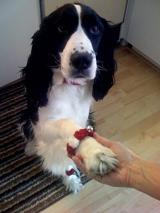

In [ ]:
image_to_grayscale = '/content/imagenette/test/English-springer/ILSVRC2012_val_00008162.JPEG'
img = Image.open(image_to_grayscale)#.convert("L")
display(img)
img.save(os.path.join('/content/', 'image.jpg'), quality=100)


# Setting up our dataloaders

In [ ]:
train_data_path = '/content/imagenette/train'
test_data_path = '/content/imagenette/test'

train_image_paths = [] #to store image paths in list
test_image_paths = []
classes = [] #to store class values

# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(sum(train_image_paths,[]))
print(len(train_image_paths))
random.shuffle(train_image_paths)

test_image_paths = list(sum(test_image_paths,[]))
print(len(test_image_paths))
random.shuffle(test_image_paths)

# create a dictionary holding corresponding class names(text) for labels(index)
# this will help when visualizing to print class names
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

9538
3856


In [ ]:
print(test_image_paths)

['/content/imagenette/test/golf-ball/n03445777_3892.JPEG', '/content/imagenette/test/fish/n01440764_8531.JPEG', '/content/imagenette/test/chain-saw/n03000684_5981.JPEG', '/content/imagenette/test/parachute/n03888257_5820.JPEG', '/content/imagenette/test/parachute/n03888257_23680.JPEG', '/content/imagenette/test/church/n03028079_10020.JPEG', '/content/imagenette/test/garbage-truck/n03417042_28610.JPEG', '/content/imagenette/test/gas-pump/n03425413_14691.JPEG', '/content/imagenette/test/French-horn/n03394916_34532.JPEG', '/content/imagenette/test/cassette-player/n02979186_22882.JPEG', '/content/imagenette/test/gas-pump/n03425413_17111.JPEG', '/content/imagenette/test/church/ILSVRC2012_val_00023291.JPEG', '/content/imagenette/test/church/n03028079_12061.JPEG', '/content/imagenette/test/chain-saw/n03000684_6632.JPEG', '/content/imagenette/test/church/n03028079_18371.JPEG', '/content/imagenette/test/gas-pump/n03425413_16962.JPEG', '/content/imagenette/test/golf-ball/n03445777_2362.JPEG', '/

In [ ]:
torch.manual_seed(42) # for reproducibility

In [ ]:
# This class derives from Dataset class in PyTorch
# Transforms are common image transformations (preprocessing steps) available in
# the torchvision.transforms module. They can be chained together using Compose.
from torch.utils.data import random_split
class ImageDataset(Dataset):

    """
    Args:
            img_paths (string): path to the images in the Tiny ImageNet Dataset Folder
            img_shape (int): size of each image in the dataset would be (img_shape,img_shape,3)
            is_tensor (callable, optional): Defines whether the images are tensors or not
    """

    def __init__(self, img_paths, img_shape, is_tensor = False):

        self.img_paths = img_paths
        self.img_shape = img_shape

        self.img_transform = transforms.Compose(
            [
                transforms.Resize((img_shape,img_shape)),
                transforms.ToTensor()
            ]
        )


    def __getitem__(self, index):
        # this function loads a single image from its path and returns the image
        # as an array along with its label
        # The __get__item function is called internally by the DataLoader function from torchvision.transforms.

        """
        Returns an example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            img: The image at the given index
            label: The label associated with the given image
        """

        img_filepath = self.img_paths[index]
        # convert image to greyscale
        img = Image.open(img_filepath)#.convert("L")
        img = self.img_transform(img)
        img = np.asarray(img)

        return img

    def __len__(self):

        """
        Returns the size of the dataset or number of examples in the dataset
        """

        return len(self.img_paths)

# tr_dt = ImageDataset(train_image_paths,img_shape=256,is_tensor=False)
# batch_size = 16
# train_loader = DataLoader(tr_dt, batch_size = batch_size, shuffle = True)

# #te_dt = ImageDataset(DataLoader, 256)
# #test_loader =  DataLoader(te_dt, batch_size = 5, shuffle = False)


# Datasets
train_dataset = ImageDataset(train_image_paths, img_shape=256, is_tensor=False)
test_dataset = ImageDataset(test_image_paths, img_shape=256, is_tensor=False)

# Define split sizes
val_split = int(0.2 * len(train_dataset))  # 20% of the training for validation
train_split = len(train_dataset) - val_split

# Randomly split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_split, val_split])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

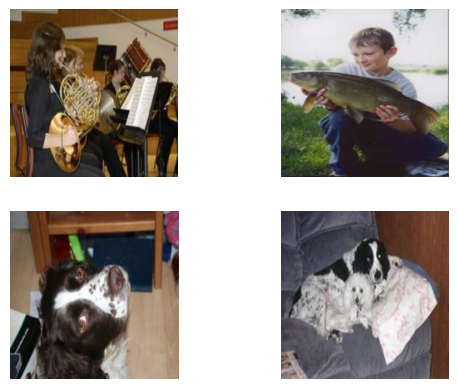

In [ ]:
#Sample Output used for visualization

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()
  #print("wha")
  #print(example.shape)
  example = example[i]
  example = example.numpy().transpose((1, 2, 0))
  #print("here")
  #print(example.shape)
  axes[i].imshow(example)
  axes[i].axis('off')
plt.show()

In [ ]:
dataset_size = len(train_loader)
print('#training images = %d' % dataset_size)

#training images = 477


Looks like the dataloader is working as intended. Lets define a few helper function to transform back into RGB when we want to visualize our images! Will be using scimage for this...


# Building the main network

In [ ]:
class SIGGRAPHGenerator(nn.Module):
    def __init__(self, dist=False):
        super(SIGGRAPHGenerator, self).__init__()
        self.dist = dist
        use_bias = True
        norm_layer = nn.BatchNorm2d

        # Conv1
        model1 = [nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [norm_layer(64), ]
        # add a subsampling operation

        # Conv2
        model2 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [norm_layer(128), ]
        # add a subsampling layer operation

        # Conv3
        model3 = [nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [norm_layer(256), ]
        # add a subsampling layer operation

        # Conv4
        model4 = [nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [norm_layer(512), ]

        # Conv5
        model5 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [norm_layer(512), ]

        # Conv6
        model6 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [norm_layer(512), ]

        # Conv7
        model7 = [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [norm_layer(512), ]

        # Conv8
        model8up = [nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=use_bias)]
        model3short8 = [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]

        model8 = [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [norm_layer(256), ]

        # Conv9
        model9up = [nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model2short9 = [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model9 = [nn.ReLU(True), ]
        model9 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model9 += [nn.ReLU(True), ]
        model9 += [norm_layer(128), ]

        # Conv10
        model10up = [nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model1short10 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model10 = [nn.ReLU(True), ]
        model10 += [nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=use_bias), ]
        model10 += [nn.LeakyReLU(negative_slope=.2), ]

        # classification output
        model_class = [nn.Conv2d(256, 529, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]

        # regression output
        model_out = [nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]
        model_out += [nn.Tanh()]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8up = nn.Sequential(*model8up)
        self.model8 = nn.Sequential(*model8)
        self.model9up = nn.Sequential(*model9up)
        self.model9 = nn.Sequential(*model9)
        self.model10up = nn.Sequential(*model10up)
        self.model10 = nn.Sequential(*model10)
        self.model3short8 = nn.Sequential(*model3short8)
        self.model2short9 = nn.Sequential(*model2short9)
        self.model1short10 = nn.Sequential(*model1short10)

        self.model_class = nn.Sequential(*model_class)
        self.model_out = nn.Sequential(*model_out)

        self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='nearest'), ])
        self.softmax = nn.Sequential(*[nn.Softmax(dim=1), ])

    def forward(self, input_A, input_B, mask_B, maskcent=0):
        # input_A \in [-50,+50]
        # input_B \in [-110, +110]
        # mask_B \in [0, +1.0]

        input_A = torch.Tensor(input_A)[None, :, :, :]
        input_B = torch.Tensor(input_B)[None, :, :, :]
        mask_B = torch.Tensor(mask_B)[None, :, :, :]
        mask_B = mask_B - maskcent

        # input_A = torch.Tensor(input_A).cuda()[None, :, :, :]
        # input_B = torch.Tensor(input_B).cuda()[None, :, :, :]
        # mask_B = torch.Tensor(mask_B).cuda()[None, :, :, :]

        # breakpoint()

        conv1_2 = self.model1(torch.cat((input_A / 100., input_B / 110., mask_B), dim=1))
        conv2_2 = self.model2(conv1_2[:, :, ::2, ::2])
        conv3_3 = self.model3(conv2_2[:, :, ::2, ::2])
        conv4_3 = self.model4(conv3_3[:, :, ::2, ::2])
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)

        if(self.dist):
            out_cl = self.upsample4(self.softmax(self.model_class(conv8_3) * .2))

            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2) * 110

            return (out_reg * 110, out_cl)
        else:
            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2)
            return out_reg * 110

# Testing images with original model parameters.


In [ ]:
# helper function
def patch_instance_norm_state_dict(state_dict, module, keys, i=0):
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)


In [ ]:
# helper function
def lab2rgb_transpose(img_l, img_ab):
    ''' INPUTS
            img_l     1xXxX     [0,100]
            img_ab     2xXxX     [-100,100]
        OUTPUTS
            returned value is XxXx3 '''
    pred_lab = np.concatenate((img_l, img_ab), axis=0).transpose((1, 2, 0))
    pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
    #pred_rgb = color.lab2rgb(pred_lab)
    return pred_rgb


def rgb2lab_transpose(img_rgb):
    ''' INPUTS
            img_rgb XxXx3
        OUTPUTS
            returned value is 3xXxX '''
    return color.rgb2lab(img_rgb).transpose((2, 0, 1))

In [ ]:
# helper function
def put_point(input_ab,mask,loc,p,val):
    # input_ab    2x256x256    current user ab input (will be updated)
    # mask        1x256x256    binary mask of current user input (will be updated)
    # loc         2 tuple      (h,w) of where to put the user input
    # p           scalar       half-patch size
    # val         2 tuple      (a,b) value of user input
    input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
    mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
    return (input_ab,mask)

In [ ]:
# helper function
# PSNR Test

from math import log10, sqrt
# import cv2
# import numpy as np

def PSNR(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): # MSE is zero means no noise is present in the signal .
				# Therefore PSNR have no importance.
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse))
	return psnr

In [ ]:
# helper function
# Change these for a different normalization routine
l_norm = 1.
ab_norm = 1.
l_mean = 50.
mask_mult = 1.
ab_mean = 0.
mask_cent = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def original_auto_test(model, input_path, display): #This is an image path to a full color image
  im = cv2.cvtColor(cv2.imread(input_path, 1), cv2.COLOR_BGR2RGB)
  img_rgb_fullres = im.copy()
  # print(img_rgb_fullres.shape)

  #func 1
  img_lab_fullres = color.rgb2lab(img_rgb_fullres).transpose((2, 0, 1))
  img_l_fullres = img_lab_fullres[[0], :, :]
  img_ab_fullres = img_lab_fullres[1:, :, :]

  im = cv2.resize(im, (256, 256))
  img_rgb = im.copy()

  #function 2
  img_lab = color.rgb2lab(img_rgb).transpose((2, 0, 1))
  img_l = img_lab[[0], :, :]
  img_ab = img_lab[1:, :, :]

  #function 3

  #normalizing
  img_lab_mc = img_lab / np.array((l_norm, ab_norm, ab_norm))[:, np.newaxis, np.newaxis] - np.array(
              (l_mean / l_norm, ab_mean / ab_norm, ab_mean / ab_norm))[:, np.newaxis, np.newaxis]

  #function 3.1
  img_l_mc = img_lab_mc[[0], :, :]

  input_ab = np.zeros((2, 256, 256)) # ab values of user points, default to 0 for no input
  input_mask = np.zeros((1, 256, 256)) # giving no user points, so mask is all 0's

  #setting different points for colorizing different sample images
  #colorizing mortar_pestle.jpg
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [135,160], 3, [23,-69]) # add a blue point in the middle of the mortar
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [100,160], 3, [0,0]) # add a gray point inside of the cup

  #colorizing image.jpg
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [37,160], 3, [78,39])
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [30,90], 3, [-73,14])

  input_ab_mc = (input_ab - ab_mean) / ab_norm
  input_mask_mult = input_mask * mask_mult

  #function _set_out_ab_()
  # Move input tensors to the GPU
  img_l_mc = torch.Tensor(img_l_mc).to(DEVICE)
  input_ab_mc = torch.Tensor(input_ab_mc).to(DEVICE)
  input_mask_mult = torch.Tensor(input_mask_mult).to(DEVICE)

  output_ab = model.forward(img_l_mc, input_ab_mc, input_mask_mult, mask_cent)[0, :, :, :].cpu().data.numpy()
  output_rgb = lab2rgb_transpose(img_l, output_ab)

  #calculating images
  img_gray_fullres = lab2rgb_transpose(img_l_fullres, np.zeros((2, img_l_fullres.shape[1], img_l_fullres.shape[2])))

  zoom_factor = (1, 1. * img_l_fullres.shape[1] / output_ab.shape[1], 1. * img_l_fullres.shape[2] / output_ab.shape[2])
  output_ab_fullres = zoom(output_ab, zoom_factor, order=1)


  img_out_fullres = lab2rgb_transpose(img_l_fullres, output_ab_fullres)

  #plotting
  if display:
    print("Grayscale, predicted, then original")
    plt.figure(figsize=(10,3))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres, img_rgb_fullres),axis=1)); plt.axis('off');
  else:
    return img_out_fullres


In [ ]:
# helper function
# Change these for a different normalization routine
l_norm = 1.
ab_norm = 1.
l_mean = 50.
mask_mult = 1.
ab_mean = 0.
mask_cent = 0

def mask_test(model, input_path, display, custom_list): # This is an image path to a full color image
  im = cv2.cvtColor(cv2.imread(input_path, 1), cv2.COLOR_BGR2RGB)
  img_rgb_fullres = im.copy()


  #func 1
  img_lab_fullres = color.rgb2lab(img_rgb_fullres).transpose((2, 0, 1))
  img_l_fullres = img_lab_fullres[[0], :, :]
  img_ab_fullres = img_lab_fullres[1:, :, :]

  im = cv2.resize(im, (256, 256))
  img_rgb = im.copy()

  #function 2
  img_lab = color.rgb2lab(img_rgb).transpose((2, 0, 1))
  img_l = img_lab[[0], :, :]
  img_ab = img_lab[1:, :, :]

  #function 3

  #normalizing
  img_lab_mc = img_lab / np.array((l_norm, ab_norm, ab_norm))[:, np.newaxis, np.newaxis] - np.array(
              (l_mean / l_norm, ab_mean / ab_norm, ab_mean / ab_norm))[:, np.newaxis, np.newaxis]

  #function 3.1
  img_l_mc = img_lab_mc[[0], :, :]

  input_ab = np.zeros((2, 256, 256)) # ab values of user points, default to 0 for no input
  input_mask = np.zeros((1, 256, 256)) # giving no user points, so mask is all 0's

  #setting different points for colorizing different sample images
  #colorizing mortar_pestle.jpg
  # (input_ab, input_mask) = put_point(input_ab, input_mask, [135,160], 3, [23,-69]) # add a blue point in the middle of the mortar
  # (input_ab, input_mask) = put_point(input_ab, input_mask, [100,160], 3, [0,0]) # add a gray point inside of the cup

  #colorizing image.jpg
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [37,160], 3, [78,39])
  #(input_ab, input_mask) = put_point(input_ab, input_mask, [30,90], 3, [-73,14])

  for loc_p_val_tuple in custom_list:
    loc = loc_p_val_tuple[0]
    p = loc_p_val_tuple[1]
    val = loc_p_val_tuple[2]
    (input_ab, input_mask) = put_point(input_ab, input_mask, loc, p, val)

  input_ab_mc = (input_ab - ab_mean) / ab_norm
  input_mask_mult = input_mask * mask_mult

  #function _set_out_ab_()
  # breakpoint()
  # Move input tensors to the GPU
  img_l_mc = torch.Tensor(img_l_mc).to(DEVICE)
  input_ab_mc = torch.Tensor(input_ab_mc).to(DEVICE)
  input_mask_mult = torch.Tensor(input_mask_mult).to(DEVICE)

  output_ab = model.forward(img_l_mc, input_ab_mc, input_mask_mult, mask_cent)[0, :, :, :].cpu().data.numpy()
  output_rgb = lab2rgb_transpose(img_l, output_ab)

  #calculating images
  img_gray_fullres = lab2rgb_transpose(img_l_fullres, np.zeros((2, img_l_fullres.shape[1], img_l_fullres.shape[2])))

  zoom_factor = (1, 1. * img_l_fullres.shape[1] / output_ab.shape[1], 1. * img_l_fullres.shape[2] / output_ab.shape[2])
  output_ab_fullres = zoom(output_ab, zoom_factor, order=1)


  img_out_fullres = lab2rgb_transpose(img_l_fullres, output_ab_fullres)

  #plotting
  if display:

    print("Grayscale, predicted, then original")
    plt.figure(figsize=(10,3))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres, img_rgb_fullres),axis=1)); plt.axis('off');
  else:
    return img_out_fullres


In [ ]:
# !wget http://colorization.eecs.berkeley.edu/siggraph/models/caffemodel.pth
# path = "/content/caffemodel.pth"
# model = SIGGRAPHGenerator(dist=False)
# state_dict = torch.load(path)

# if hasattr(state_dict, '_metadata'):
#     del state_dict._metadata

# model.load_state_dict(state_dict)
# model.to(DEVICE)
# model.eval()

In [ ]:
import torch
from torch.utils.model_zoo import load_url

def load_pretrained_model(model, url):
    print("Loading pre-trained weights...")
    state_dict = load_url(url, map_location='cpu', check_hash=True)

    # Delete metadata if it exists
    if hasattr(state_dict, '_metadata'):
        del state_dict._metadata

    model.load_state_dict(state_dict, strict=False)
    print("Weights loaded successfully.")

model = SIGGRAPHGenerator(dist=False)
load_pretrained_model(model, 'https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth')
model.to(DEVICE)

Loading pre-trained weights...
Weights loaded successfully.


SIGGRAPHGenerator(
  (model1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace

In [ ]:
# Check if pre-trained parameters are loaded correctly
def compare_keys(model, state_dict):
    model_keys = set(model.state_dict().keys())
    pretrained_keys = set(state_dict.keys())

    missing_keys = model_keys - pretrained_keys
    extra_keys = pretrained_keys - model_keys

    print("Missing Keys (not loaded):")
    print(missing_keys)
    print("\nExtra Keys (ignored):")
    print(extra_keys)

state_dict = torch.utils.model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth', map_location='cpu', check_hash=True)
compare_keys(model, state_dict)

Missing Keys (not loaded):
set()

Extra Keys (ignored):
set()


# These Images are generated from the model without a mask

To use original_auto_test:
For the custom_list argument:
Pass in a list of 1 tuple or more tuple.
Each tuple should contain:


1.   loc: a list of 2 coordinates specifying where you wish to put a point on the specific image you are colorizing.
2.   p: a scalar representing half-patch size.
3. val: a list of 2 values representing the A and B LAB values for the custom color you want.



In [ ]:
test_image_dog = "/content/imagenette/train/English-springer/ILSVRC2012_val_00002294.JPEG"

(160, 213, 3)
Grayscale, predicted, then original
(160, 213, 3)
PSNR value is 29.838128373937415 dB


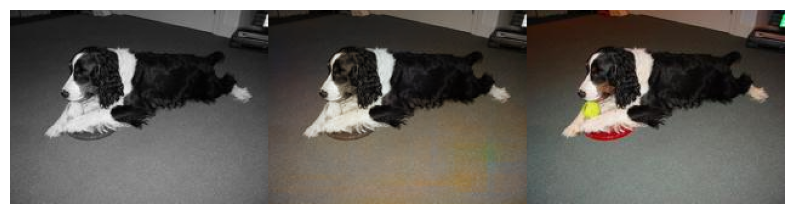

In [ ]:
original_auto_test(model, input_path = test_image_dog, display = True)
original = cv2.imread(test_image_dog)
compressed = original_auto_test(model, input_path = test_image_dog, display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

In [ ]:
test_image_church = "/content/imagenette/train/church/ILSVRC2012_val_00006268.JPEG"

(208, 160, 3)
Grayscale, predicted, then original
(208, 160, 3)
PSNR value is 29.289445051428167 dB


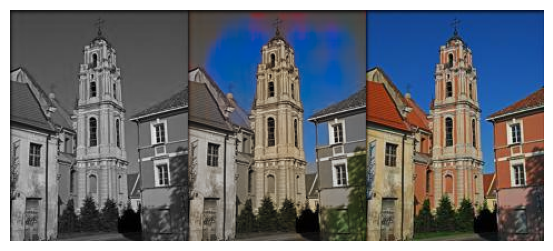

In [ ]:
original_auto_test(model, input_path = test_image_church, display = True)

original = cv2.imread(test_image_church)
compressed = original_auto_test(model, input_path = test_image_church, display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

# These images have been generated with hints given

Grayscale, predicted, then original
(160, 213, 3)
PSNR value is 31.39081578697066 dB


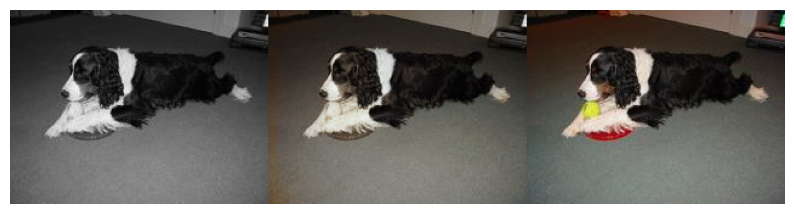

In [ ]:
my_custom_list = [([129,175], 3, [-2.67,1.53])]
mask_test(model, input_path = test_image_dog, display = True, custom_list = my_custom_list)
original = cv2.imread(test_image_dog)
compressed = mask_test(model, input_path = test_image_dog, display = False,  custom_list = my_custom_list)
print(np.array(compressed).shape)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')


Grayscale, predicted, then original
(160, 213, 3)
PSNR value is 32.27262081209758 dB


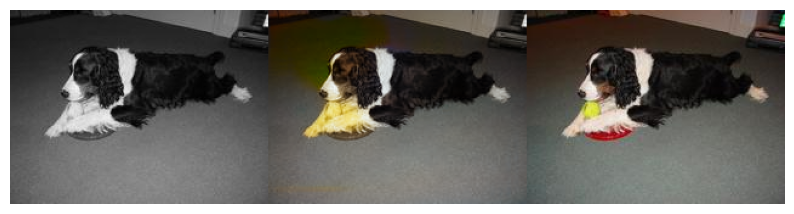

In [ ]:
my_custom_list = [([82,52], 1, [-20.91, 73.7]),([134,33], 3, [-2.67,1.53]), ([129,175], 3, [-2.67,1.53])]
mask_test(model, input_path = test_image_dog, display = True, custom_list = my_custom_list)
original = cv2.imread(test_image_dog)
compressed = mask_test(model, input_path = test_image_dog, display = False,  custom_list = my_custom_list)
print(np.array(compressed).shape)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

# Fine-tuning with Imagenette


In [ ]:
# Some helper functions for getting the masks

# Change these for a different normalization routine
l_norm = 1.
ab_norm = 1.
l_mean = 50.
mask_mult = 1.
ab_mean = 0.
mask_cent = 0
sample_Ps = 1.

def get_colorization_data(data_raw, ab_thresh=5., p=.125, num_points=None):
  data = {}

  data_restack = []

  for item in data_raw:
    # data_lab_temp2 = rgb2lab(item)
    data_lab_temp = torch.Tensor(color.rgb2lab(item.to("cpu").permute((1, 2, 0))).transpose((2, 0, 1))).to(DEVICE)
    data_restack.append(data_lab_temp)


  # len(data_restack)

  data_lab = torch.stack(data_restack).to(DEVICE)

  data['a'] = data_lab[:,[0,],:,:]
  data['b'] = data_lab[:,1:,:,:]

  if(ab_thresh > 0):
    thresh = 1.*ab_thresh/ab_norm
    mask = torch.sum(torch.abs(torch.max(torch.max(data['b'], dim=3)[0], dim=2)[0]-torch.min(torch.min(data['b'], dim=3)[0], dim=2)[0]), dim=1) >= thresh
    data['a'] = data['a'][mask,:,:,:]
    data['b'] = data['b'][mask,:,:,:]
    if(torch.sum(mask)==0):
      return None

  return add_color_patches(data, p=p, num_points=num_points)

def add_color_patches(data, p=.125, num_points=None, use_avg=True, samp='normal'):

  # I want the whole image here

#   # Add random color points sampled from ground truth based on:
# #   Number of points
# #   - if num_points is 0, then sample from geometric distribution, drawn from probability p
# #   - if num_points > 0, then sample that number of points
# #   Location of points
# #   - if samp is 'normal', draw from N(0.5, 0.25) of image
# #   - otherwise, draw from U[0, 1] of image
    N,C,H,W = data['b'].shape

    data['hint_b'] = torch.zeros_like(data['b'])
    data['mask_b'] = torch.zeros_like(data['a'])

    for nn in range(N):
        pp = 0
        cont_cond = True
        while(cont_cond):
            if(num_points is None): # draw from geometric
                # embed()
                cont_cond = np.random.rand() < (1-p)
            else: # add certain number of points
                cont_cond = pp < num_points
            if(not cont_cond): # skip out of loop if condition not met
                continue

            P = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, ]) # patch size

            # sample location
            if(samp=='normal'): # geometric distribution
                h = int(np.clip(np.random.normal( (H-P+1)/2., (H-P+1)/4.), 0, H-P))
                w = int(np.clip(np.random.normal( (W-P+1)/2., (W-P+1)/4.), 0, W-P))
            else: # uniform distribution
                h = np.random.randint(H-P+1)
                w = np.random.randint(W-P+1)

            # add color point
            if(use_avg):
                # embed()
                data['hint_b'][nn,:,h:h+P,w:w+P] = torch.mean(torch.mean(data['b'][nn,:,h:h+P,w:w+P],dim=2,keepdim=True),dim=1,keepdim=True).view(1,C,1,1)
            else:
                data['hint_b'][nn,:,h:h+P,w:w+P] = data['b'][nn,:,h:h+P,w:w+P]

            data['mask_b'][nn,:,h:h+P,w:w+P] = 1

            # increment counter
            pp+=1

    data['mask_b']-=mask_cent

    return data

In [ ]:
def validate(loader, model, loss_fn):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data_raw in loader:
            data_raw = data_raw.to(DEVICE)
            data = get_colorization_data(data_raw)
            for j in range(data['a'].shape[0]):
                output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                loss = loss_fn(output, data['b'][j][None, :, :, :])
                val_losses.append(loss.item())
    avg_val_loss = torch.mean(torch.FloatTensor(val_losses))
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999))
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Initialize storage for losses
# train_losses_iter = []  # Training loss every 100 iterations
# train_losses_epoch = []  # Average training loss every epoch
# val_losses_epoch = []  # Validation loss every epoch

plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


def train_and_validate_with_iteration_loss(model, train_loader, val_loader, optimizer, loss_fn, epochs, log_interval=100):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training Phase
        model.train()
        running_train_loss = 0.0
        for i, data_raw in enumerate(train_loader, 1):  # Start index from 1 for logging
            data_raw = data_raw.to(DEVICE)
            data = get_colorization_data(data_raw)

            # Training step
            optimizer.zero_grad()
            loss_sum = 0.0
            for j in range(data['a'].shape[0]):
                output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                loss = loss_fn(output, data['b'][j][None, :, :, :])
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            batch_loss = loss_sum / data['a'].shape[0]
            running_train_loss += batch_loss

            # Log training loss every log_interval iterations
            if i % log_interval == 0:
                train_losses_iter.append(batch_loss)
                print(f"Iteration {i}, Batch Loss: {batch_loss:.4f}")

        # Compute average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses_epoch.append(avg_train_loss)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data_raw in val_loader:
                data_raw = data_raw.to(DEVICE)
                data = get_colorization_data(data_raw)
                loss_sum = 0.0
                for j in range(data['a'].shape[0]):
                    output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                    loss = loss_fn(output, data['b'][j][None, :, :, :])
                    loss_sum += loss.item()
                running_val_loss += loss_sum / data['a'].shape[0]

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses_epoch.append(avg_val_loss)


        print(f"Epoch {epoch + 1} Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        plateau_scheduler.step(avg_val_loss)

    return train_losses_iter, train_losses_epoch, val_losses_epoch


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<ipython-input-53-65dc1dc328b5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1.pth')
<ipy

Grayscale, predicted, then original
PSNR value is 27.8961966832404 dB


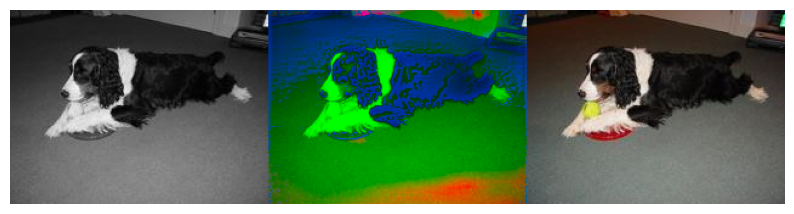

In [ ]:
model = SIGGRAPHGenerator(dist=False)
state_dict = torch.load('/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1.pth')
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
original_auto_test(model, input_path = test_image_dog, display = True)
original = cv2.imread(test_image_dog)
compressed = original_auto_test(model, input_path = test_image_dog, display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

In [ ]:
# Train and Validate
train_losses_iter, train_losses_epoch, val_losses_epoch = train_and_validate_with_iteration_loss(
    model, train_loader, val_loader, optimizer, torch.nn.functional.huber_loss, epochs=5
)

torch.save(model.state_dict(), '/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1.pth')
print("Model saved to Google Drive!")

plot_training_loss(train_losses_iter)
plot_training_validation_loss(train_losses_epoch, val_losses_epoch)

# # Disconnect runtime
# import os
# os.kill(os.getpid(), 9)

<ipython-input-51-6630c0b88fbd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1.pth')


NameError: name 'train_and_validate_with_iteration_loss' is not defined

In [ ]:
def plot_training_loss(train_losses_iter):
  # Plot Training Loss Every 100 Iterations
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses_iter, label='Training Loss (Every 100 Iterations)')
  plt.xlabel('Iterations (x100)')
  plt.ylabel('Loss')
  plt.title('Training Loss Every 100 Iterations')
  plt.legend()
  plt.grid()
  plt.show()

def plot_training_validation_loss(train_losses_epoch, val_losses_epoch):
  # Plot Training and Validation Loss per Epoch
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(train_losses_epoch) + 1), train_losses_epoch, label='Training Loss (Per Epoch)')
  plt.plot(range(1, len(val_losses_epoch) + 1), val_losses_epoch, label='Validation Loss (Per Epoch)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Per Epoch')
  plt.legend()
  plt.grid()
  plt.show()
plot_training_loss(train_losses_iter)
plot_training_validation_loss(train_losses_epoch, val_losses_epoch)

# Finetuning with changes


Bad validation loss:
1. Add learning rate scheduler and reduce initial learning rate to 5e-6
2. Add regularization: weight_decay

In [ ]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)

from torch.optim.lr_scheduler import ReduceLROnPlateau

warmup_epochs = 5

# warm-Up scheduler for slowly increasing learning rate
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)
# plateau scheduler to reduce learning rate when there's overfitting
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Initialize storage for losses
train_losses_iter = []
train_losses_epoch = []
val_losses_epoch = []

def train_and_validate_with_iteration_loss(model, train_loader, val_loader, optimizer, loss_fn, epochs, log_interval=100):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training Phase
        model.train()
        running_train_loss = 0.0
        for i, data_raw in enumerate(train_loader, 1):  # Start index from 1 for logging
            data_raw = data_raw.to(DEVICE)
            data = get_colorization_data(data_raw)

            # Training step
            optimizer.zero_grad()
            loss_sum = 0.0
            for j in range(data['a'].shape[0]):
                output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                loss = loss_fn(output, data['b'][j][None, :, :, :])
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            batch_loss = loss_sum / data['a'].shape[0]
            running_train_loss += batch_loss

            # Log training loss every log_interval iterations
            if i % log_interval == 0:
                train_losses_iter.append(batch_loss)
                print(f"Iteration {i}, Batch Loss: {batch_loss:.4f}")

        # Compute average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses_epoch.append(avg_train_loss)

        # Warm-up scheduler
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}")


        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data_raw in val_loader:
                data_raw = data_raw.to(DEVICE)
                data = get_colorization_data(data_raw)
                loss_sum = 0.0
                for j in range(data['a'].shape[0]):
                    output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                    loss = loss_fn(output, data['b'][j][None, :, :, :])
                    loss_sum += loss.item()
                running_val_loss += loss_sum / data['a'].shape[0]

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses_epoch.append(avg_val_loss)

        print(f"Epoch {epoch + 1} Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Plateau scheduler (starts after warm-up)
        if epoch >= warmup_epochs:
            plateau_scheduler.step(avg_val_loss)


    return train_losses_iter, train_losses_epoch, val_losses_epoch


NameError: name 'model' is not defined

In [ ]:
# Train and Validate
train_losses_iter, train_losses_epoch, val_losses_epoch = train_and_validate_with_iteration_loss(
    model, train_loader, val_loader, optimizer, torch.nn.functional.huber_loss, epochs=15
)

Epoch 1/15
Iteration 100, Batch Loss: 5.6790
Iteration 200, Batch Loss: 6.8792
Iteration 300, Batch Loss: 5.6708
Iteration 400, Batch Loss: 7.3544
Current LR: 1.400000e-06
Epoch 1 Train Loss: 6.5633, Validation Loss: 5.3806
Epoch 2/15
Iteration 100, Batch Loss: 6.6929
Iteration 200, Batch Loss: 5.5972
Iteration 300, Batch Loss: 7.2837
Iteration 400, Batch Loss: 6.4882
Current LR: 2.300000e-06
Epoch 2 Train Loss: 6.0930, Validation Loss: 5.6641
Epoch 3/15
Iteration 100, Batch Loss: 6.6009
Iteration 200, Batch Loss: 5.1554
Iteration 300, Batch Loss: 6.7461
Iteration 400, Batch Loss: 6.4770
Current LR: 3.200000e-06
Epoch 3 Train Loss: 5.8523, Validation Loss: 5.5143
Epoch 4/15
Iteration 100, Batch Loss: 4.4084
Iteration 200, Batch Loss: 4.5700
Iteration 300, Batch Loss: 6.7054
Iteration 400, Batch Loss: 5.4884
Current LR: 4.100000e-06
Epoch 4 Train Loss: 5.7265, Validation Loss: 5.4418
Epoch 5/15
Iteration 100, Batch Loss: 6.7944
Iteration 200, Batch Loss: 6.5494
Iteration 300, Batch Loss

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1to5.pth')
print("Model saved to Google Drive!")

Model saved to Google Drive!


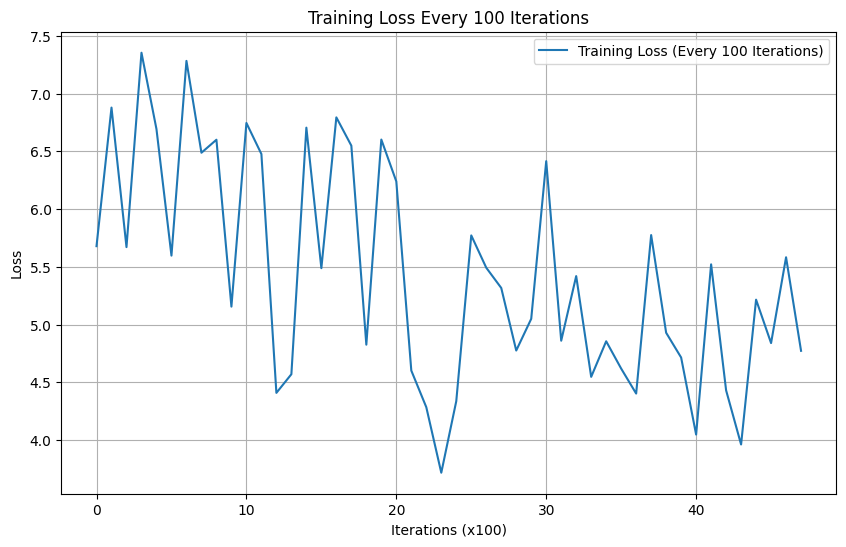

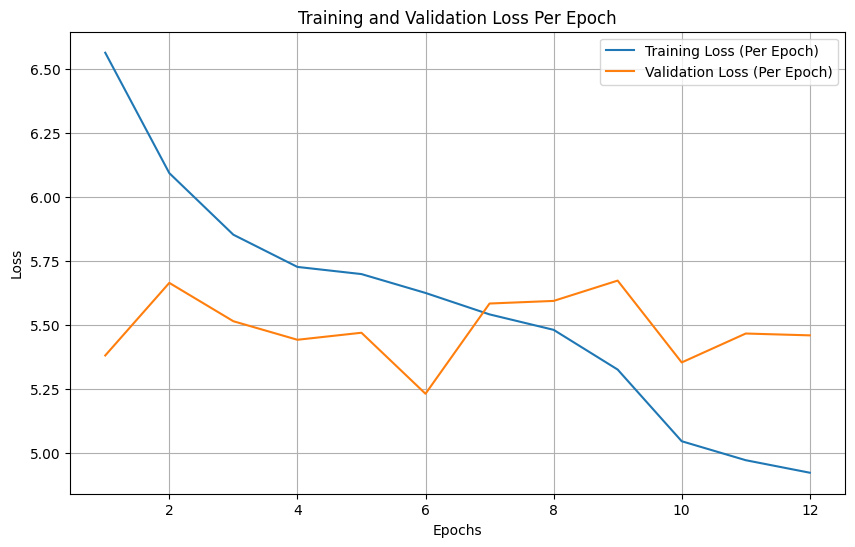

In [ ]:
plot_training_loss(train_losses_iter)
plot_training_validation_loss(train_losses_epoch, val_losses_epoch)

<ipython-input-44-bc3221f83281>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1to5.pth')


(160, 213, 3)
Grayscale, predicted, then original
(160, 213, 3)
PSNR value is 28.421501005517417 dB


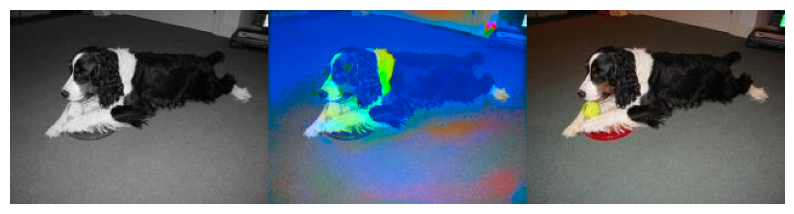

In [ ]:
model = SIGGRAPHGenerator(dist=False)
state_dict = torch.load('/content/drive/MyDrive/CV_project/siggraph_finetuned_lr1to5.pth')
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
original_auto_test(model, input_path = test_image_dog, display = True)
original = cv2.imread(test_image_dog)
compressed = original_auto_test(model, input_path = test_image_dog, display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

In [ ]:
def evaluate_test(model, test_loader, loss_fn):
    """
    Evaluate the model on the test dataset.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        loss_fn: Loss function to compute the test loss.

    Returns:
        float: Average test loss.
    """
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_batches = len(test_loader)

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data_raw in test_loader:
            data_raw = data_raw.to(DEVICE)
            data = get_colorization_data(data_raw)

            batch_loss = 0.0
            for j in range(data['a'].shape[0]):  # Iterate through each sample in the batch
                output = model(data['a'][j], data['hint_b'][j], data['mask_b'][j])
                loss = loss_fn(output, data['b'][j][None, :, :, :])
                batch_loss += loss.item()

            # Accumulate test loss
            running_test_loss += batch_loss / data['a'].shape[0]

    avg_test_loss = running_test_loss / total_batches
    return avg_test_loss

test_loss = evaluate_test(model, test_loader, loss_fn=torch.nn.functional.huber_loss)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 5.5295


In [ ]:
def test_PSNR(model, test_loader):
    """
    Compute average PSNR on the test dataset using the model and test_loader.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader containing batches of test images.

    Returns:
        float: Average PSNR across the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    psnr_values = []  # Store PSNR values

    with torch.no_grad():
        for image_path in test_image_paths:  # Assuming test_loader.dataset provides image paths
            # Call original_auto_test to get predicted image
            predicted_image = original_auto_test(model, input_path=image_path, display=False)

            # Read the original image
            original_image = cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2RGB)

            # Resize original image to match predicted image dimensions
            resized_original = cv2.resize(original_image, (predicted_image.shape[1], predicted_image.shape[0]))

            # Compute PSNR between predicted and original
            psnr_value = PSNR(predicted_image, resized_original)
            psnr_values.append(psnr_value)

    # Compute average PSNR
    avg_psnr = sum(psnr_values) / len(psnr_values)
    return avg_psnr

average_psnr = test_PSNR(model, test_loader)
print(f"Average Test PSNR: {average_psnr:.2f}")

<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 121 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
<ipython-input-12-e82decf8af54>:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 53 negative Z values that have been clipped to zero
  pred_rgb = (np.clip(color.lab2rgb(pred_lab), 0, 1) * 255).astype('uint8')
<ipython-input-12-e82decf8af54>:9: U

Average Test PSNR: 28.24


# GAN

In [ ]:
class SIGGRAPHGenerator(nn.Module):
    def __init__(self, dist=False):
        super(SIGGRAPHGenerator, self).__init__()
        self.dist = dist
        use_bias = True
        norm_layer = nn.BatchNorm2d

        self.class_encoder = nn.Conv2d(10, 1, kernel_size=1, bias=use_bias)

        # Conv1
        model1 = [nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [norm_layer(64), ]
        # add a subsampling operation

        # Conv2
        model2 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [norm_layer(128), ]
        # add a subsampling layer operation

        # Conv3
        model3 = [nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [norm_layer(256), ]
        # add a subsampling layer operation

        # Conv4
        model4 = [nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [norm_layer(512), ]

        # Conv5
        model5 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model5 += [nn.ReLU(True), ]
        model5 += [norm_layer(512), ]

        # Conv6
        model6 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        model6 += [nn.ReLU(True), ]
        model6 += [norm_layer(512), ]

        # Conv7
        model7 = [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [norm_layer(512), ]

        # Conv8
        model8up = [nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=use_bias)]
        model3short8 = [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]

        model8 = [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [norm_layer(256), ]

        # Conv9
        model9up = [nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model2short9 = [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model9 = [nn.ReLU(True), ]
        model9 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model9 += [nn.ReLU(True), ]
        model9 += [norm_layer(128), ]

        # Conv10
        model10up = [nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model1short10 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model10 = [nn.ReLU(True), ]
        model10 += [nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=use_bias), ]
        model10 += [nn.LeakyReLU(negative_slope=.2), ]

        # classification output
        model_class = [nn.Conv2d(256, 529, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]

        # regression output
        model_out = [nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]
        model_out += [nn.Tanh()]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8up = nn.Sequential(*model8up)
        self.model8 = nn.Sequential(*model8)
        self.model9up = nn.Sequential(*model9up)
        self.model9 = nn.Sequential(*model9)
        self.model10up = nn.Sequential(*model10up)
        self.model10 = nn.Sequential(*model10)
        self.model3short8 = nn.Sequential(*model3short8)
        self.model2short9 = nn.Sequential(*model2short9)
        self.model1short10 = nn.Sequential(*model1short10)

        self.model_class = nn.Sequential(*model_class)
        self.model_out = nn.Sequential(*model_out)

        self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='nearest'), ])
        self.softmax = nn.Sequential(*[nn.Softmax(dim=1), ])

    def forward(self, input_A, input_B, class_info):
        # Process class_info (e.g., via a fully connected or convolutional layer)
        class_features = self.class_encoder(class_info)  # Reduce class channels
        concatenated_input = torch.cat((input_A / 100., input_B / 110., class_features), dim=1)

        # Combine class_features with input_A
        input_A = torch.cat((input_A, class_features), dim=1)

        # Proceed with the rest of the forward pass
        conv1_2 = self.model1(torch.cat((input_A / 100., input_B / 110.), dim=1))
        conv2_2 = self.model2(conv1_2[:, :, ::2, ::2])
        conv3_3 = self.model3(conv2_2[:, :, ::2, ::2])
        conv4_3 = self.model4(conv3_3[:, :, ::2, ::2])
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)

        if self.dist:
            out_cl = self.upsample4(self.softmax(self.model_class(conv8_3) * .2))

            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2) * 110

            return (out_reg * 110, out_cl)
        else:
            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2)
            return out_reg * 110


In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
class ImageDataset(Dataset):
    """
    Args:
        img_paths (list): List of image paths.
        img_shape (int): Size of each image (img_shape, img_shape, 3).
        class_to_idx (dict): Dictionary mapping class names to indices.
    """

    def __init__(self, img_paths, img_shape, class_to_idx):
        self.img_paths = img_paths
        self.img_shape = img_shape
        self.class_to_idx = class_to_idx  # Class-to-index mapping

        self.img_transform = transforms.Compose(
            [
                transforms.Resize((img_shape, img_shape)),
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, index):
        img_filepath = self.img_paths[index]
        img = Image.open(img_filepath).convert("RGB")  # Open image as RGB
        img = self.img_transform(img)

        # Extract the class name from the file path
        class_name = img_filepath.split('/')[-2]  # Assuming path structure: <class_name>/<image>
        label = self.class_to_idx[class_name]  # Get the label index

        # Convert to grayscale
        grayscale = transforms.Grayscale()(img)  # Convert to grayscale
        return grayscale, img, label  # Return grayscale, color, and label

    def __len__(self):
        return len(self.img_paths)


In [ ]:
# Datasets
train_dataset = ImageDataset(train_image_paths, img_shape=256, class_to_idx=class_to_idx)
test_dataset = ImageDataset(test_image_paths, img_shape=256, class_to_idx=class_to_idx)

# # Define split sizes
# val_split = int(0.2 * len(train_dataset))  # 20% of the training data for validation
# train_split = len(train_dataset) - val_split

# # Randomly split the dataset
# train_dataset, val_dataset = random_split(train_dataset, [train_split, val_split])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# Load the pretrained Siggraph generator
generator = SIGGRAPHGenerator(dist=False)
load_pretrained_model(generator, 'https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth')
generator.to(DEVICE)
generator.eval()
state_dict = torch.utils.model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth', map_location='cpu', check_hash=True)
compare_keys(model, state_dict)

Loading pre-trained weights...


RuntimeError: Error(s) in loading state_dict for SIGGRAPHGenerator:
	size mismatch for model1.0.weight: copying a param with shape torch.Size([64, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(13, 64, kernel_size=4, stride=2, padding=1),  # 1 (grayscale) + 10 (class one-hot) + 2 (fake_color channels)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self, x):
        return self.model(x).view(-1)  # Flatten to single value for real/fake classification


In [ ]:
for epoch in range(10):
    for grayscale, color, labels in train_loader:  # Ensure train_loader provides grayscale and color
        # Move data to the device
        grayscale, color, labels = grayscale.to(DEVICE), color.to(DEVICE), labels.to(DEVICE)

        # One-hot encode class labels for conditional GAN
        class_one_hot = F.one_hot(labels, num_classes=10).float()
        class_one_hot = class_one_hot.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        class_one_hot = class_one_hot.expand(-1, -1, grayscale.size(2), grayscale.size(3))  # Match input size
        class_one_hot = class_one_hot.to(DEVICE)

        # Prepare inputs for SIGGRAPHGenerator
        input_A = grayscale  # Grayscale input
        input_B = torch.zeros_like(input_A)  # Ensure input_B matches input_A's shape
        input_A.to(DEVICE)
        input_B.to(DEVICE)
        # mask_B = torch.zeros_like(input_A)  # Fully grayscale mask

        # Debug shapes
        print(f"Shape of input_A: {input_A.shape}")
        print(f"Shape of input_B: {input_B.shape}")
        # print(f"Shape of mask_B: {mask_B.shape}")
        print(f"Shape of class_one_hot: {class_one_hot.shape}")

        # class_info_encoder = nn.Conv2d(10, 1, kernel_size=1).to(DEVICE)  # Reduce to 1 channel
        # class_info = class_info_encoder(class_one_hot)
        # grayscale_cond = torch.cat([grayscale, class_info], dim=1)  # Concatenate reduced class info

        # Train discriminator
        fake_color = generator(input_A, input_B, class_one_hot).detach()
        real_label = torch.full((grayscale.size(0),), 0.9, device=DEVICE)  # Smoothed real labels
        fake_label = torch.zeros((grayscale.size(0),), device=DEVICE)

        # Real images with class condition
        real_input = torch.cat([grayscale, color], dim=1)  # Combine grayscale and real color
        real_loss = adversarial_loss(discriminator(real_input), real_label)

        # Fake images with class condition
        fake_input = torch.cat([grayscale, fake_color], dim=1)
        fake_loss = adversarial_loss(discriminator(fake_input), fake_label)

        disc_loss = (real_loss + fake_loss) / 2

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Train generator
        fake_color = generator(input_A, input_B)
        gen_adv_loss = adversarial_loss(discriminator(fake_input), real_label)
        gen_pixel_loss = pixel_loss(fake_color, color)
        gen_loss = alpha * gen_pixel_loss + beta * gen_adv_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

    # Scheduler Step
    gen_scheduler.step()
    disc_scheduler.step()

    # Track losses and PSNR
    psnr = 10 * torch.log10(1 / torch.mean((fake_color - color) ** 2))
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}, PSNR: {psnr.item():.2f}")


Shape of input_A: torch.Size([16, 1, 256, 256])
Shape of input_B: torch.Size([16, 1, 256, 256])
Shape of class_one_hot: torch.Size([16, 10, 256, 256])


RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[16, 3, 256, 256] to have 4 channels, but got 3 channels instead

# Using Tuned weights

In [ ]:
!wget http://colorization.eecs.berkeley.edu/siggraph/models/pytorch.pth

--2024-12-17 08:07:22--  http://colorization.eecs.berkeley.edu/siggraph/models/pytorch.pth
Resolving colorization.eecs.berkeley.edu (colorization.eecs.berkeley.edu)... 128.32.244.190
Connecting to colorization.eecs.berkeley.edu (colorization.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136785828 (130M)
Saving to: ‘pytorch.pth’

pytorch.pth         100%[===================>] 130.45M  72.9MB/s    in 1.8s    

2024-12-17 08:07:24 (72.9 MB/s) - ‘pytorch.pth’ saved [136785828/136785828]



In [ ]:
path = "/content/pytorch.pth"

In [ ]:
model = SIGGRAPHGenerator(dist=False).to(DEVICE)
state_dict = torch.load(path)

if hasattr(state_dict, '_metadata'):
    del state_dict._metadata

model.load_state_dict(state_dict)
model.eval()

<ipython-input-70-38a99cb88725>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


SIGGRAPHGenerator(
  (model1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace

In [ ]:
train(10)

Training start!
Start training epoch 1
Iteration 0, Average Loss: 8.6000
Iteration 100, Average Loss: 8.6000
Iteration 200, Average Loss: 9.8003
Iteration 300, Average Loss: 9.7652
Loss of discriminator D: 9.765
Epoch 1 completed in 143.46s
Start training epoch 2
Iteration 0, Average Loss: 7.3792
Iteration 100, Average Loss: 7.3792
Iteration 200, Average Loss: 9.4398
Loss of discriminator D: 9.440
Epoch 2 completed in 93.97s
Start training epoch 3
Iteration 0, Average Loss: 9.2782
Iteration 100, Average Loss: 9.2782
Iteration 200, Average Loss: 10.0444
Iteration 300, Average Loss: 10.0251
Loss of discriminator D: 10.025
Epoch 3 completed in 142.44s
Start training epoch 4
Iteration 0, Average Loss: 15.4416
Iteration 100, Average Loss: 15.4416
Iteration 200, Average Loss: 9.9102
Iteration 300, Average Loss: 10.0059
Iteration 400, Average Loss: 9.9685
Loss of discriminator D: 9.969
Epoch 4 completed in 189.60s
Start training epoch 5
Iteration 0, Average Loss: 11.5078
Iteration 100, Averag

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/CV_project/final_model/pyth_model_tuned.pth")

In [ ]:
path = '/content/drive/MyDrive/CV_project/final_model/pyth_model_tuned.pth'

In [ ]:
net = SIGGRAPHGenerator(dist=False)
state_dict = torch.load(path)

if hasattr(state_dict, '_metadata'):
    del state_dict._metadata

net.load_state_dict(state_dict)
net.eval()

<ipython-input-82-ada737a6b5d2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


SIGGRAPHGenerator(
  (model1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace

Grayscale, predicted, then original
PSNR value is 31.25010252204023 dB


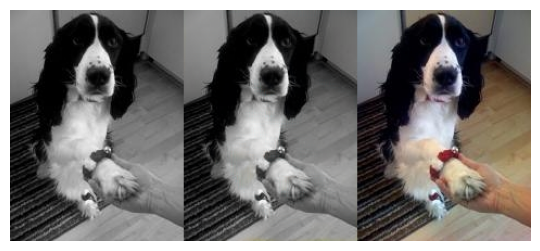

In [ ]:
original_auto_test(input_path = '/content/english-springer.jpg', display = True)

original = cv2.imread("/content/english-springer.jpg")
compressed = original_auto_test(input_path = '/content/english-springer.jpg', display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

Now with a blue point:

Grayscale, predicted, then original
PSNR value is 31.912649597367757 dB


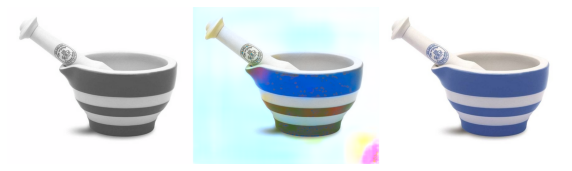

In [ ]:
my_custom_list = [([135,160], 3, [23,-69]), ([100,160], 3, [0,0])]
mask_test(input_path = '/content/mortar_pestle.jpg', display = True, custom_list = my_custom_list)
original = cv2.imread("/content/mortar_pestle.jpg")

compressed = mask_test(input_path = '/content/mortar_pestle.jpg', display = False,  custom_list = my_custom_list)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

# Building our modified network

In [ ]:
class SIGGRAPHGenerator(nn.Module):
    def __init__(self, dist=False):
        super(SIGGRAPHGenerator, self).__init__()
        self.dist = dist
        use_bias = True
        norm_layer = nn.BatchNorm2d

        # Conv1
        model1 = [nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model1 += [nn.ReLU(True), ]
        model1 += [norm_layer(64), ]
        # add a subsampling operation

        # Conv2
        model2 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model2 += [nn.ReLU(True), ]
        model2 += [norm_layer(128), ]
        # add a subsampling layer operation

        # Conv3
        model3 = [nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model3 += [nn.ReLU(True), ]
        model3 += [norm_layer(256), ]
        # add a subsampling layer operation

        # Conv4
        model4 = [nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model4 += [nn.ReLU(True), ]
        model4 += [norm_layer(512), ]

        # # Conv5
        # model5 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model5 += [nn.ReLU(True), ]
        # model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model5 += [nn.ReLU(True), ]
        # model5 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model5 += [nn.ReLU(True), ]
        # model5 += [norm_layer(512), ]

        # # Conv6
        # model6 = [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model6 += [nn.ReLU(True), ]
        # model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model6 += [nn.ReLU(True), ]
        # model6 += [nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias), ]
        # model6 += [nn.ReLU(True), ]
        # model6 += [norm_layer(512), ]

        # Conv7
        model7 = [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model7 += [nn.ReLU(True), ]
        model7 += [norm_layer(512), ]

        # Conv8
        model8up = [nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=use_bias)]
        model3short8 = [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]

        model8 = [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model8 += [nn.ReLU(True), ]
        model8 += [norm_layer(256), ]

        # Conv9
        model9up = [nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model2short9 = [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model9 = [nn.ReLU(True), ]
        model9 += [nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        model9 += [nn.ReLU(True), ]
        model9 += [norm_layer(128), ]

        # Conv10
        model10up = [nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=use_bias), ]
        model1short10 = [nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias), ]
        # add the two feature maps above

        model10 = [nn.ReLU(True), ]
        model10 += [nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=use_bias), ]
        model10 += [nn.LeakyReLU(negative_slope=.2), ]

        # classification output
        model_class = [nn.Conv2d(256, 529, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]

        # regression output
        model_out = [nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias), ]
        model_out += [nn.Tanh()]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        # self.model5 = nn.Sequential(*model5)
        # self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8up = nn.Sequential(*model8up)
        self.model8 = nn.Sequential(*model8)
        self.model9up = nn.Sequential(*model9up)
        self.model9 = nn.Sequential(*model9)
        self.model10up = nn.Sequential(*model10up)
        self.model10 = nn.Sequential(*model10)
        self.model3short8 = nn.Sequential(*model3short8)
        self.model2short9 = nn.Sequential(*model2short9)
        self.model1short10 = nn.Sequential(*model1short10)

        self.model_class = nn.Sequential(*model_class)
        self.model_out = nn.Sequential(*model_out)

        self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='nearest'), ])
        self.softmax = nn.Sequential(*[nn.Softmax(dim=1), ])

    def forward(self, input_A, input_B, mask_B, maskcent=0):
        # input_A \in [-50,+50]
        # input_B \in [-110, +110]
        # mask_B \in [0, +1.0]

        input_A = torch.Tensor(input_A)[None, :, :, :]
        input_B = torch.Tensor(input_B)[None, :, :, :]
        mask_B = torch.Tensor(mask_B)[None, :, :, :]
        mask_B = mask_B - maskcent

        # input_A = torch.Tensor(input_A).cuda()[None, :, :, :]
        # input_B = torch.Tensor(input_B).cuda()[None, :, :, :]
        # mask_B = torch.Tensor(mask_B).cuda()[None, :, :, :]

        #breakpoint()

        conv1_2 = self.model1(torch.cat((input_A / 100., input_B / 110., mask_B), dim=1))
        conv2_2 = self.model2(conv1_2[:, :, ::2, ::2])
        conv3_3 = self.model3(conv2_2[:, :, ::2, ::2])
        conv4_3 = self.model4(conv3_3[:, :, ::2, ::2])
        # conv5_3 = self.model5(conv4_3)
        # conv6_3 = self.model6(conv4_3)
        conv7_3 = self.model7(conv4_3)

        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3)
        conv8_3 = self.model8(conv8_up)

        if(self.dist):
            out_cl = self.upsample4(self.softmax(self.model_class(conv8_3) * .2))

            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2) * 110

            return (out_reg * 110, out_cl)
        else:
            conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2)
            conv9_3 = self.model9(conv9_up)
            conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2)
            conv10_2 = self.model10(conv10_up)
            out_reg = self.model_out(conv10_2)
            return out_reg * 110

In [ ]:
G = SIGGRAPHGenerator().to(DEVICE)
G

SIGGRAPHGenerator(
  (model1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace

Sadly this does not work as intended. We use Scipy's implementation instead:

In [ ]:
def rgb2lab (input) :

  RGB = [None, None, None]

  for num, value in enumerate(input) :
      value = value / 255

      x = ((value + 0.055) / 1.055) ** 2.4
      y = value / 12.92

      #  if value > 0.04045 :
      #      value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
      #  else :
      #      value = value / 12.92

      value = torch.where(value > 0.04045, x, y)
      RGB[num] = value * 100


  XYZ = [None, None, None]

  X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
  Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
  Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505

  XYZ[ 0 ] = torch.round(X, decimals = 4)
  XYZ[ 1 ] = torch.round(Y, decimals = 4)
  XYZ[ 2 ] = torch.round(Z, decimals = 4)

  XYZ[0] = XYZ[0].float() / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
  XYZ[1] = XYZ[1].float() / 100.0          # ref_Y = 100.000
  XYZ[2] = XYZ[2].float() / 108.883        # ref_Z = 108.883

  for num, value in enumerate(XYZ) :

    x = value ** (1/3.)
    y = value * 7.787 + 16 / 116

    # if value > 0.008856 :
    #     value = value ** ( 0.3333333333333333 )
    # else :
    #     value = ( 7.787 * value ) + ( 16 / 116 )

    value = torch.where(value > 0.008856, x, y)
    XYZ[num] = value

  Lab = [None, None, None]

  L = ( 116 * XYZ[ 1 ] ) - 16
  a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
  b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

  Lab [ 0 ] = torch.round(L, decimals = 4)
  Lab [ 1 ] = torch.round(a, decimals = 4)
  Lab [ 2 ] = torch.round(b, decimals = 4)

  return torch.stack(Lab)

# Training this

In [ ]:
model = SIGGRAPHGenerator(dist=False).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
train(10)

Training start!
Start training epoch 1
Iteration 0, Average Loss: 12.1201
Iteration 100, Average Loss: 12.1201
Iteration 200, Average Loss: 9.4541
Iteration 300, Average Loss: 9.2347
Iteration 400, Average Loss: 9.1231
Iteration 500, Average Loss: 8.9661
Iteration 600, Average Loss: 8.9029
Iteration 700, Average Loss: 8.8393
Iteration 800, Average Loss: 8.7208
Iteration 900, Average Loss: 8.6962
Loss of discriminator D: 8.696
Epoch 1 completed in 327.78s
Start training epoch 2
Iteration 0, Average Loss: 9.0998
Iteration 100, Average Loss: 9.0998
Iteration 200, Average Loss: 8.1499
Loss of discriminator D: 8.150
Epoch 2 completed in 72.86s
Start training epoch 3
Iteration 0, Average Loss: 10.1272
Iteration 100, Average Loss: 10.1272
Iteration 200, Average Loss: 7.8050
Iteration 300, Average Loss: 7.8909
Iteration 400, Average Loss: 7.9337
Loss of discriminator D: 7.934
Epoch 3 completed in 144.47s
Start training epoch 4
Iteration 0, Average Loss: 6.2708
Iteration 100, Average Loss: 6.27

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/CV_project/final_model/from_scratch.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/CV_project/final_model/from_scratch.pth'

In [ ]:
net = SIGGRAPHGenerator(dist=False)
state_dict = torch.load(path)

if hasattr(state_dict, '_metadata'):
    del state_dict._metadata

net.load_state_dict(state_dict)
net.eval()

<ipython-input-91-ada737a6b5d2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


SIGGRAPHGenerator(
  (model1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace

Grayscale, predicted, then original
PSNR value is 30.87736003767683 dB


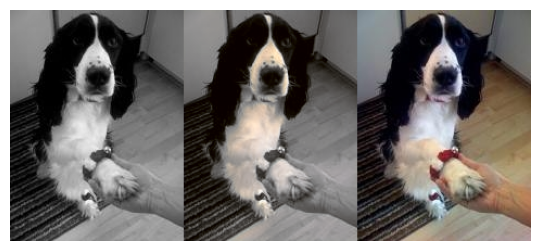

In [ ]:
original_auto_test(input_path = '/content/english-springer.jpg', display = True)

original = cv2.imread("/content/english-springer.jpg")
compressed = original_auto_test(input_path = '/content/english-springer.jpg', display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Grayscale, predicted, then original
PSNR value is 28.185789698624024 dB


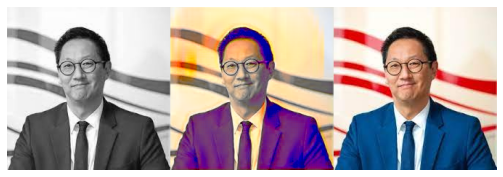

In [ ]:
original_auto_test(input_path = '/content/SantaOno.jfif', display = True)

original = cv2.imread("/content/SantaOno.jfif")
compressed = original_auto_test(input_path = '/content/SantaOno.jfif', display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Grayscale, predicted, then original
PSNR value is 28.588100856158178 dB


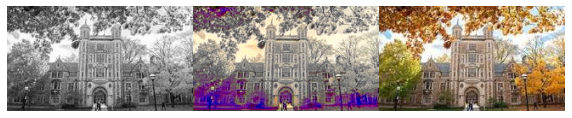

In [ ]:
original_auto_test(input_path = '/content/law_quad.jfif', display = True)

original = cv2.imread("/content/law_quad.jfif")
compressed = original_auto_test(input_path = '/content/law_quad.jfif', display = False)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")

Grayscale, predicted, then original
PSNR value is 32.22139319006243 dB


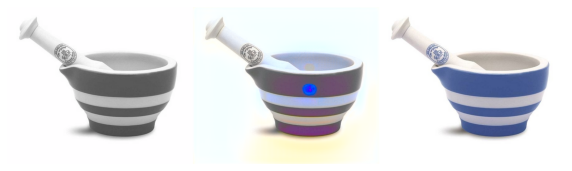

In [ ]:
my_custom_list = [([135,160], 3, [23,-69]), ([100,160], 3, [0,0])]
mask_test(input_path = '/content/mortar_pestle.jpg', display = True, custom_list = my_custom_list)
original = cv2.imread("/content/mortar_pestle.jpg")

compressed = mask_test(input_path = '/content/mortar_pestle.jpg', display = False,  custom_list = my_custom_list)
value = PSNR(original, compressed)
print(f"PSNR value is {value} dB")